In [7]:
from pyspark.sql.functions import radians, sin, cos, sqrt, atan2, col, lit
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import sum as sql_sum
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


# Create SparkSession
spark = SparkSession.builder.appName("ChallengerTemperatureAnalysis").getOrCreate()

# Define haversine distance UDF
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    dlon = radians(lon2) - radians(lon1)
    dlat = radians(lat2) - radians(lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Define inverse distance weighting UDF
def idw(distances, temperatures):
    weights = 1 / distances
    weighted_temps = temperatures * weights
    return sql_sum(weighted_temps) / sql_sum(weights)


# Read station and temperature data
stations = spark.read.csv("../data/stations.csv", header=True, inferSchema=True)
temperatures = spark.read.csv("../data/1986.csv", header=False, inferSchema=True) \
                     .toDF("station_id", "wban_id", "month", "day", "temperature")

# Filter and clean up the data
stations = stations.filter((stations["latitude"].isNotNull()) & (stations["longitude"].isNotNull()))
temperatures = temperatures.filter((temperatures["temperature"].isNotNull()) & (temperatures["month"] == 1) & (temperatures["day"] == 28))

# Join stations and temperatures data
joined = temperatures.join(stations, ["station_id", "wban_id"])

# Compute distances from each station to Cape Canaveral (28.3922° N, 80.6077° W)
lat_cc = lit(28.3922)
lon_cc = lit(-80.6077)
joined = joined.withColumn("distance", haversine(lat_cc, lon_cc, joined["latitude"], joined["longitude"]).cast(DoubleType()))

# Filter for stations within 100 km of Cape Canaveral
joined = joined.filter(joined["distance"] <= 100)

# Compute IDW temperature at Cape Canaveral on January 28, 1986
idw_temp = joined.groupby().agg(idw(col("distance"), col("temperature")).alias("IDW_Temperature")).collect()[0]["IDW_Temperature"]

# Print result
print("The estimated temperature at Cape Canaveral on January 28, 1986, using inverse distance weighting, is {:.2f} degrees F.".format(idw_temp))


The estimated temperature at Cape Canaveral on January 28, 1986, using inverse distance weighting, is 34.46 degrees F.


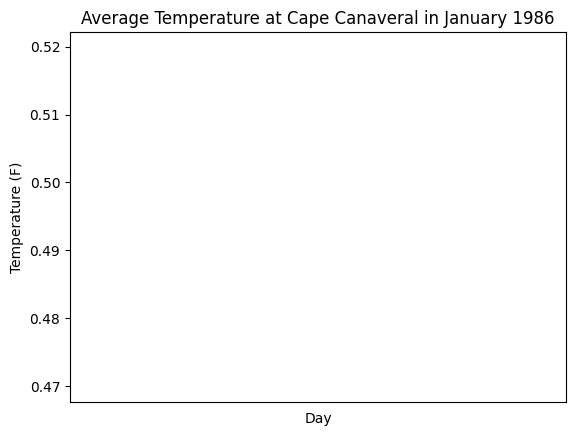

In [18]:
# Aggregate temperature data by date
daily_temps = joined.filter(joined["temperature"].isNotNull()) \
                     .groupby("day") \
                     .agg(sql_sum(col("temperature")).alias("total_temperature"), sql_sum(col("distance")).alias("total_distance")) \
                     .withColumn("average_temperature", col("total_temperature") / col("total_distance"))

import matplotlib.pyplot as plt

days = daily_temps.select("day").collect()
temps = daily_temps.select("average_temperature").collect()

plt.plot([day[0] for day in days], [temp[0] for temp in temps])
plt.title("Average Temperature at Cape Canaveral in January 1986")
plt.xlabel("Day")
plt.ylabel("Temperature (F)")

# Set x-axis limits to show the entire month of January
plt.xlim(1, 31)

plt.show()



In [16]:
print(daily_temps.count())


1
